# Import

In [94]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [95]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 200

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}_00"

In [96]:
file_name

'MyResNet32_128_SGD_00'

# Loading the dataset

## Define Dateloader

In [97]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [98]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)


train.transforms = Compose(
      Compose(
        ToImage()
        ToDtype(scale=True)
  )
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
test.transforms = Compose(
      ToImage()
      ToDtype(scale=True)
) 128


# Define ResNet

## Model Confirm

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [100]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [101]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [102]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [103]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [104]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
# scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.1, cooldown=40)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [105]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [106]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_00
Current epoch is 240
Current learning rate: 0.0010000000000000002


In [107]:
optimizer.param_groups[0]["lr"]

0.0010000000000000002

In [108]:
earlystopper.early_stop_counter

8

# [Training Loop]

In [109]:
# Training = DoTraining(
#     model=model,
#     criterion=criterion,
#     optimizer=optimizer,
#     scaler=scaler,
#     scheduler=scheduler,
#     earlystopper=earlystopper,
#     device=device,
#     logs=logs,
#     file_path=file_name,
# )
# pre_epochs = len(Training.logs["train_loss"])


# for epoch in range(NUM_EPOCHS):
#     now = epoch + 1 + pre_epochs
#     print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

#     if DATASET == "ImageNet2012":
#         eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
#     else:
#         eval_loss = Training.SingleEpoch(
#             train_dataloader, valid_dataloader, test_dataloader
#         )

#     Training.Save()

    
    
#     if earlystopper.check(eval_loss) == True:
#         break

#     print("-" * 50)

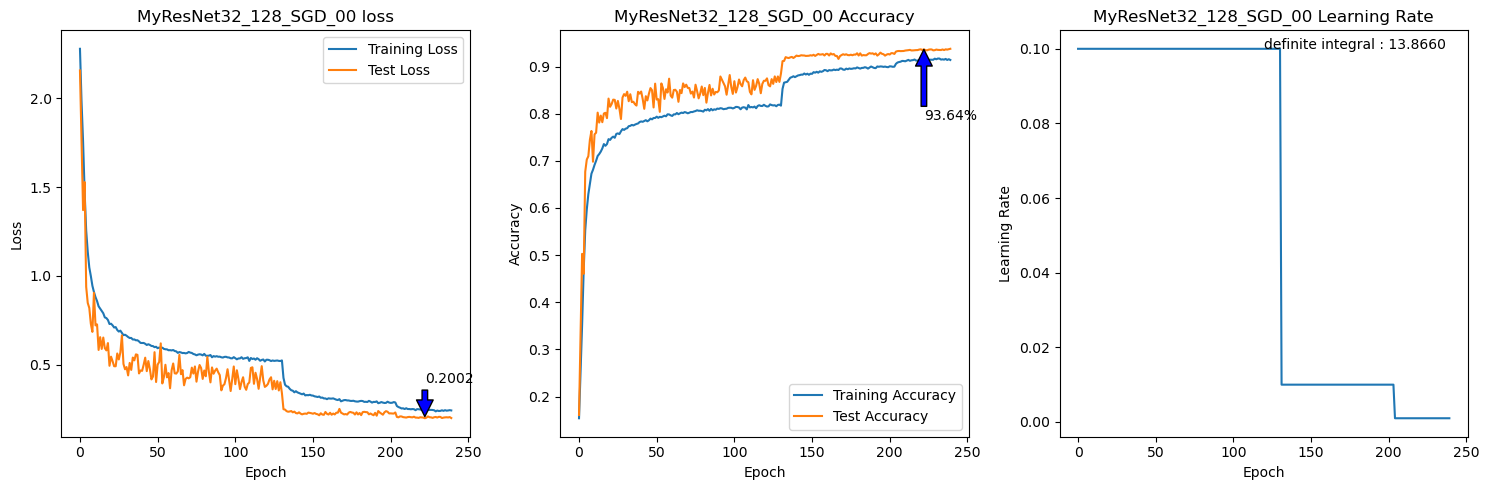

In [110]:
view = LogViewer(logs)
view.draw(title=file_name, min_marker=True, add_lr_plot=True, save=True)

In [111]:
view.print_all()

1 epoch: train_loss=2.2771, train_acc=0.1541, test_loss=2.1554, test_acc=0.1610, lr=0.1000
2 epoch: train_loss=1.9825, train_acc=0.2540, test_loss=1.7491, test_acc=0.3353, lr=0.1000
3 epoch: train_loss=1.7559, train_acc=0.3527, test_loss=1.3702, test_acc=0.5027, lr=0.1000
4 epoch: train_loss=1.4722, train_acc=0.4679, test_loss=1.5281, test_acc=0.4605, lr=0.1000
5 epoch: train_loss=1.2556, train_acc=0.5528, test_loss=0.9390, test_acc=0.6769, lr=0.1000
6 epoch: train_loss=1.1366, train_acc=0.5968, test_loss=0.8486, test_acc=0.7027, lr=0.1000
7 epoch: train_loss=1.0481, train_acc=0.6293, test_loss=0.8204, test_acc=0.7098, lr=0.1000
8 epoch: train_loss=0.9995, train_acc=0.6518, test_loss=0.7311, test_acc=0.7446, lr=0.1000
9 epoch: train_loss=0.9450, train_acc=0.6728, test_loss=0.6859, test_acc=0.7633, lr=0.1000
10 epoch: train_loss=0.9098, train_acc=0.6811, test_loss=0.9054, test_acc=0.6981, lr=0.1000
11 epoch: train_loss=0.8811, train_acc=0.6914, test_loss=0.7224, test_acc=0.7562, lr=0.10